In [70]:
import csv
import glob
import json
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from collections import OrderedDict
from tabulate import tabulate

sns.set_context("notebook")
sns.set_style("whitegrid")

plt.rcParams['figure.dpi'] = 300
plt.rcParams['axes.linewidth'] = 0.5
plt.rcParams['grid.linewidth'] = 0.5
plt.rcParams['patch.linewidth'] = 0.0

palette = sns.color_palette("magma", 2)

In [60]:
class Log:
    def __init__(self, PID, gesture, task, target, block, startTime, endTime, frames=None):
        self.PID = PID
        self.gesture = gesture
        self.task = task
        self.target = target
        self.block = block
        self.startTime = startTime
        self.endTime = endTime
        if frames is None:
            self.frames = []
        else:
            self.frames = frames

    def __str__(self):
        return str(self.__class__) + ": " + str(self.__dict__)

class Frame:
    def __init__(self, activity, state, cursor_X, cursor_y, slider_position_X, slider_value, message=""):
        self.activity = activity
        self.state = state
        self.cursor_X = cursor_X
        self.cursor_y = cursor_y
        self.slider_position_X = slider_position_X
        self.slider_value = slider_value
        self.message = message

    def __str__(self):
        return str(self.__class__) + ": " + str(self.__dict__)

def extract_data(jsonData):
    """
    Parse json into an instance of the Log class.
    """
    frames = []

    for f in jsonData["frames"]:
        frames.append(Frame(f["activity"], f["state"], f["cursor_X"], f["cursor_y"], f["slider_position_X"], f["slider_value"], f["message"] if "message" in f else ""))

    return Log(jsonData["PID"], jsonData["gesture"], jsonData["task"], jsonData["target"], jsonData["block"], jsonData["startTime"], jsonData["endTime"], frames)

def first_pinch_position(data: Log):
    """
    Extracts the (x, y) position of the cursor when the first pinch was detected.
    """
    current_block_num = 0
    
    for frame in data.frames:
        # Log file for task N also includes all data for tasks 0 to N-1, so we need to skip these
        if current_block_num < data.block:
            if frame.activity.startswith("BlockCompleted"):
                current_block_num = int(frame.message.split(" ")[1]) + 1
            
            continue
        
        # Now we've skipped to the right part, we can check for when the first pinch was detected
        if frame.message == "Transitioning from states NoPinchDetected to PinchDetected":
            return (frame.cursor_X, frame.cursor_y)

columnNames = ["P", "Condition", "Task", "X", "Y"]
data = pd.DataFrame(columns = columnNames)

files = glob.glob("../Logs/*/*/*/*.json")
log: Log

for file in files:
    with open(file) as json_file:
        pid = file.split("/")[-4]
        condition = file.split("/")[-2]
        task = file.split("/")[-3]

        if pid not in ["-1", "1", "2", "3", "4"] and condition in ["pinchAny", "pinchOnCircle"]:
            log = extract_data(json.load(json_file))

            (first_x, first_y) = first_pinch_position(log)

            log_data = pd.DataFrame(columns = columnNames, data = [[pid, condition, task, first_x, first_y]])
            data = pd.concat([data, log_data], ignore_index=True)

In [97]:
#data_filtered = data.drop(data[data.Condition == "Pinch" and data.X > 700].index)

data_filtered = data.drop(data[(data.Condition == "pinchOnCircle") & (data.X > 700)].index)

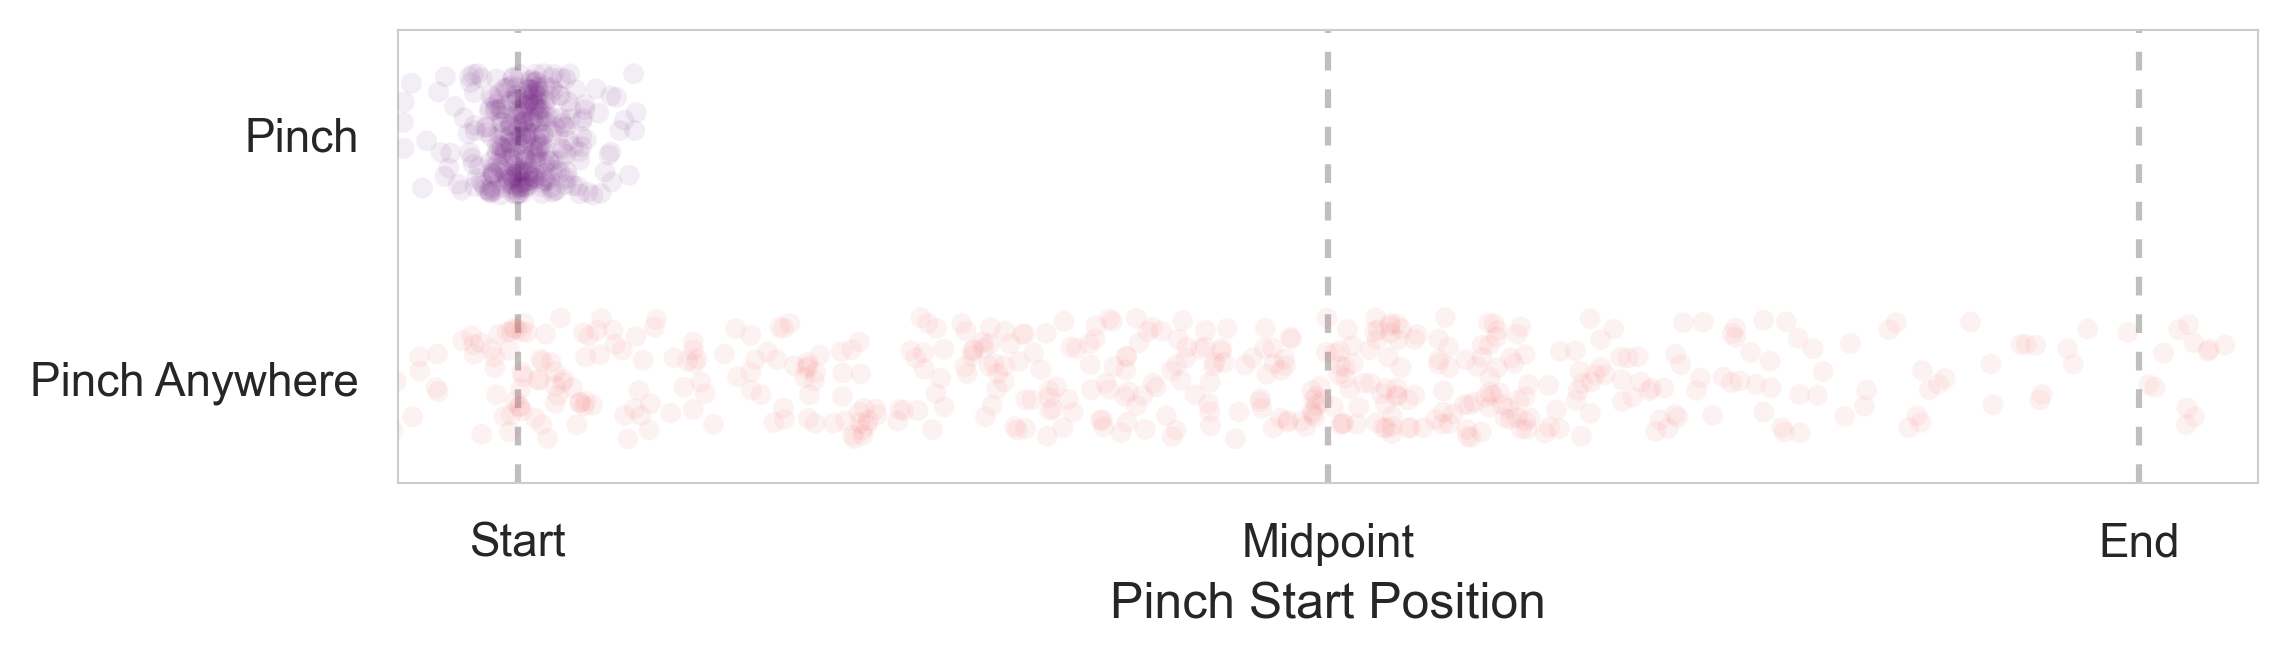

In [109]:
plot, axis = plt.subplots(figsize=(8, 2))

# Annotations
plt.axvline(600, 0, 1, dashes=[3, 3], alpha=0.5, color="grey")  # Slider left
plt.axvline(1280, 0, 1, dashes=[3, 3], alpha=0.5, color="grey") # Show monitor centre
plt.axvline(1960, 0, 1, dashes=[3, 3], alpha=0.5, color="grey") # Slider right

# Points
sns.stripplot(x="X", y="Condition", hue="Condition", data=data_filtered, palette=palette, jitter=0.25, alpha=0.08)
#sns.pointplot(x="X", y="Condition", hue="Condition", data=data_filtered, palette=palette, join=False, errwidth=1.2, scale=1.5, ci=95)

# Prepare x-axis
axis.set(xlim=(500, 2060))
axis.set_xlabel("Pinch Start Position")
plt.xticks([600, 1280, 1960], ['Start', 'Midpoint', 'End'])

# Prepare y-axis
axis.set_ylabel("")
plt.yticks([0, 1], ['Pinch', 'Pinch Anywhere'])

# Hide legend
plt.legend([],[], frameon=False)

# Hide grid
axis.grid(False) 

# Fix margins
axis.margins(x=0.05, y=0.12)

plot.savefig("Plots/Pinch.pdf", bbox_inches='tight')